In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Dropout, Flatten, BatchNormalization, GlobalAveragePooling2D, Conv2D, MaxPooling2D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
import os
import cv2

2024-11-11 16:29:39.548251: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1731342579.568531   22607 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1731342579.574840   22607 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-11 16:29:39.595631: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# Define image dimensions and paths
IMG_HEIGHT, IMG_WIDTH = 224, 224
data_dir = 'Chess'

images, labels = [], []

# Map each folder name to a numerical label
class_names = os.listdir(data_dir)
label_map = {name: idx for idx, name in enumerate(class_names)}

# Load images and labels
for label, class_name in enumerate(class_names):
    class_dir = os.path.join(data_dir, class_name)
    for img_file in os.listdir(class_dir):
        img_path = os.path.join(class_dir, img_file)
        
        # Load image and check if it's loaded correctly
        img = cv2.imread(img_path)
        if img is None:
            print(f"Warning: Unable to load image {img_path}")
            continue  

        img = cv2.resize(img, (IMG_HEIGHT, IMG_WIDTH))
        images.append(img)
        labels.append(label_map[class_name])

images = np.array(images)
labels = np.array(labels)


In [3]:
# Normalize pixel values
images = images / 255.0

# Split dataset into train, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(images, labels, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

In [4]:
# Define the data generator with augmentation
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    zoom_range=0.2
)

train_gen = datagen.flow(X_train, y_train, batch_size=32)
val_gen = ImageDataGenerator().flow(X_val, y_val, batch_size=32)
test_gen = ImageDataGenerator().flow(X_test, y_test, batch_size=32)

In [5]:
print("Class-to-label mapping:")
for class_name, label in label_map.items():
    print(f"{class_name}: {label}")

Class-to-label mapping:
Bishop: 0
King: 1
Knight: 2
Pawn: 3
Queen: 4
Rook: 5


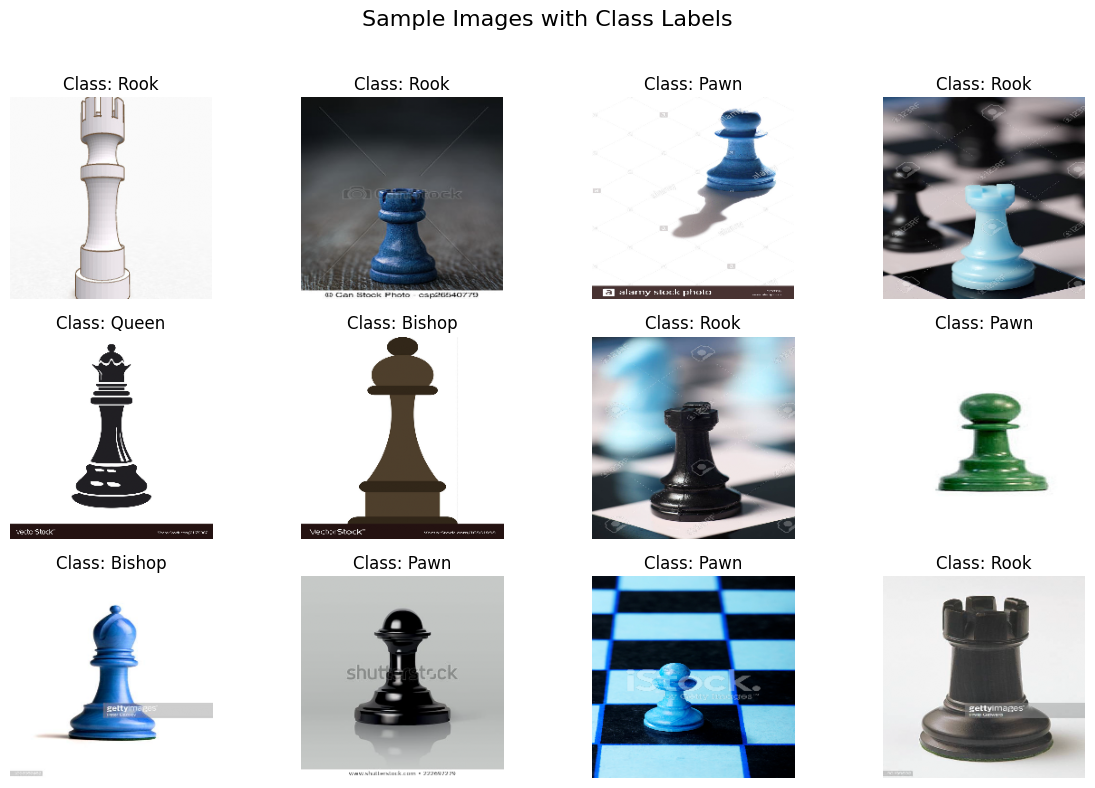

In [6]:
import matplotlib.pyplot as plt
import numpy as np

# Number of images to display
num_images = 12
# Define grid dimensions for displaying images
grid_rows, grid_cols = 3, 4

# Generate random indices to sample images from the dataset
indices = np.random.choice(len(X_train), num_images, replace=False)
sample_images = X_train[indices]
sample_labels = y_train[indices]

# Create a plot with specified number of rows and columns
fig, axes = plt.subplots(grid_rows, grid_cols, figsize=(12, 8))
fig.suptitle('Sample Images with Class Labels', fontsize=16)

# Loop through each subplot and display an image with its label
for i, ax in enumerate(axes.flat):
    # Display image
    ax.imshow(sample_images[i])
    # Set title as the class label
    ax.set_title(f"Class: {class_names[sample_labels[i]]}")
    ax.axis('off')  # Hide the axes for clarity

plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust layout to make space for the title
plt.show()

In [7]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.models import Model

# Load the pre-trained VGG16 model without the top classification layers
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the pre-trained layers
for layer in base_model.layers:
    layer.trainable = False

# Add custom classification layers on top of VGG16
x = Flatten()(base_model.output)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(5, activation='softmax')(x)

# Create the final model
model = Model(inputs=base_model.input, outputs=output)

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Display a summary of the model's architecture
model.summary()

I0000 00:00:1731342586.503585   22607 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 20933 MB memory:  -> device: 0, name: NVIDIA A10G, pci bus id: 0000:00:1e.0, compute capability: 8.6


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │    12,845,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 5)              │           64

 Total params: 27,626,565 (105.39 MB)

 Trainable params: 12,911,877 (49.25 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [8]:
# Callbacks
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_chessman_model.keras', save_best_only=True, monitor='val_loss')

# Train the model
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=100,
    callbacks=[early_stopping, model_checkpoint]
)

/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/100


I0000 00:00:1731342589.357383   22907 service.cc:148] XLA service 0x7f43fc00ffc0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1731342589.357425   22907 service.cc:156]   StreamExecutor device (0): NVIDIA A10G, Compute Capability 8.6
2024-11-11 16:29:49.390462: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1731342589.584402   22907 cuda_dnn.cc:529] Loaded cuDNN version 90300


 1/14 ━━━━━━━━━━━━━━━━━━━━ 1:15 6s/step - accuracy: 0.1562 - loss: nan

I0000 00:00:1731342593.909234   22907 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


14/14 ━━━━━━━━━━━━━━━━━━━━ 17s 824ms/step - accuracy: 0.1546 - loss: nan - val_accuracy: 0.1636 - val_loss: nan
Epoch 2/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 3s 225ms/step - accuracy: 0.1461 - loss: nan - val_accuracy: 0.1636 - val_loss: nan
Epoch 3/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 3s 228ms/step - accuracy: 0.1142 - loss: nan - val_accuracy: 0.1636 - val_loss: nan
Epoch 4/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 3s 224ms/step - accuracy: 0.1382 - loss: nan - val_accuracy: 0.1636 - val_loss: nan
Epoch 5/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 3s 226ms/step - accuracy: 0.1443 - loss: nan - val_accuracy: 0.1636 - val_loss: nan
Epoch 6/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 3s 224ms/step - accuracy: 0.1686 - loss: nan - val_accuracy: 0.1636 - val_loss: nan
Epoch 7/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 3s 226ms/step - accuracy: 0.1704 - loss: nan - val_accuracy: 0.1636 - val_loss: nan
Epoch 8/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 3s 228ms/step - accuracy: 0.1438 - loss: nan - val_accuracy: 0.1636 - val_loss: nan
Epoch 9/100
14/14 ━━━━━━━━━